### TODO

* [x] Load files from the same animal
* [x] Use MatchID to build decoder
* [x] Train on left reward days, test on right
* [x] Compare this to test performance on left
* [ ] Make a plot of results (trained on left, plot results on right)
* [ ] Make a plot of results (trained on LOGO left)

What is our hypothesis again?

That decoder performance for reward prediction decays w reversal while it doesn't for position?
The OFC activity then represents the expectation of reward, not the position, and therefore we can use it to say something about how fast or slow re-learning reward is?


In [87]:
cd /home/blansdel/dnb2_backup_01-26-2025/schwarz/decoder

/home/blansdel/dnb2_backup_01-26-2025/schwarz/decoder


In [88]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

In [89]:
pwd

'/home/blansdel/dnb2_backup_01-26-2025/schwarz/decoder'

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from typing import Final

from sklearn.metrics import accuracy_score, confusion_matrix

from decoder_plotting import *

base_dir = '/home/blansdel/projects/schwarz/decoder/Retracked/'

animals = ['Control Animal 1', 'Control Animal 10', 'Control Animal M3', 'Clonodine Animal F4', 'IDX Animal F3']

sample_dirs = [os.path.join(base_dir, a) for a in animals]
sample_dirs


['/home/blansdel/projects/schwarz/decoder/Retracked/Control Animal 1',
 '/home/blansdel/projects/schwarz/decoder/Retracked/Control Animal 10',
 '/home/blansdel/projects/schwarz/decoder/Retracked/Control Animal M3',
 '/home/blansdel/projects/schwarz/decoder/Retracked/Clonodine Animal F4',
 '/home/blansdel/projects/schwarz/decoder/Retracked/IDX Animal F3']

In [91]:
#Train the position decoder on this many rows
N_ROWS: Final = 200000

In [105]:
fn_in = 'retracked_results/results_animal_Control Animal 1.pkl'
# fn_in = 'retracked_results/results_animal_Control Animal 10.pkl'
# fn_in = 'retracked_results/results_animal_Control Animal M3.pkl'
# fn_in = 'retracked_results/results_animal_Clonidine Animal F4.pkl'
# fn_in = 'retracked_results/results_animal_IDX Animal F3.pkl'

with open(fn_in, 'rb') as f:
    results = pickle.load(f)
test_accuracy_by_group = results['test_accuracy_by_group']

test_groups = results['test_groups']
y_pred_test = results['y_pred_test']
y_test_kmeans = results['y_test_kmeans']
maze_choice = results['trial_choice_test']
y_test_pos = results['y_test_pos']
test_events = results['test_events']

#for each group, get the maze choice
group_to_maze_choice = {}
for group in test_groups.unique():
    group_to_maze_choice[group.split('Rds-')[1]] = maze_choice[test_groups == group].iloc[0]


In [106]:
group_to_maze_choice

{'7.0-01': 'left',
 '7.0-02': 'both',
 '7.0-03': 'both',
 '7.0-04': 'both',
 '7.0-05': 'right',
 '7.0-06': 'right',
 '7.0-07': 'both',
 '7.0-08': 'both',
 '7.0-09': 'right',
 '7.0-10': 'both',
 '7.0-11': 'both',
 '7.0-12': 'both',
 '9.0-01': 'left',
 '9.0-02': 'both',
 '9.0-03': 'right',
 '9.0-04': 'both',
 '9.0-05': 'both',
 '9.0-06': 'right',
 '9.0-07': 'right',
 '9.0-08': 'right',
 '9.0-09': 'right',
 '9.0-10': 'right',
 '9.0-11': 'right',
 '9.0-12': 'both'}

In [93]:
events_and_groups = pd.DataFrame({'event': test_events, 'kmeans': y_test_kmeans})
events_and_groups.groupby(['kmeans', 'event']).count()

Empty DataFrame
Columns: []
Index: [(0, In Left Exit), (0, lspout_exit), (1, In Left), (1, In Left Exit), (1, In Left Spout), (1, lspout_exit), (1, lspout_first), (2, In Reward), (2, In Right), (2, In Right Exit), (2, rspout_exit), (2, rspout_first), (3, In Start), (3, middle_left), (3, middle_right), (4, In Right Exit), (4, rspout_exit), (5, In Left), (5, In Left decision), (5, lspout_first), (5, middle_left), (5, middle_right), (6, In Left), (6, In Left Exit), (6, In Left decision), (6, lspout_exit), (6, lspout_first), (7, In Right Exit), (7, In Start), (7, rspout_exit), (8, In Left Exit), (8, In Start), (8, lspout_exit), (8, rspout_exit), (9, In Right), (9, In Right decision), (9, middle_left), (9, middle_right), (9, rspout_first)]

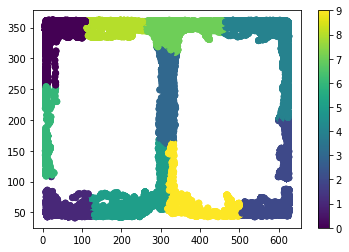

In [94]:
plt.scatter(y_test_pos[:, 0], y_test_pos[:, 1], c=y_test_kmeans)
plt.colorbar()

(array([29011., 18810., 17205.,  2920.,  8831.,  1550.,  1980., 11044.,
        10072.,  2331.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

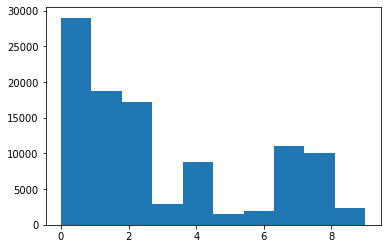

In [95]:
plt.figure()
plt.hist(y_test_kmeans, bins=10)

(array([3.0983e+04, 6.3019e+04, 4.5120e+03, 4.7300e+02, 2.9000e+01,
        1.4560e+03, 2.3600e+02, 2.6410e+03, 2.9400e+02, 1.1100e+02]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

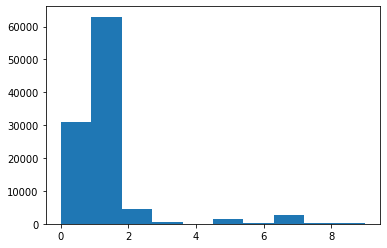

In [96]:
plt.figure()
plt.hist(y_pred_test, bins=10)

In [97]:
accuracy = accuracy_score(y_test_kmeans, y_pred_test)
print("Accuracy:", accuracy)

Accuracy: 0.2947838155637373


In [98]:
#Reshape predictions to be by group
y_pred_test_by_group = []
y_test_kmeans_by_group = []
for group in test_groups.unique():
    pred_counts = np.unique(y_pred_test[test_groups == group], return_counts=True)
    #Fill in missing values with zero
    pred_counts = dict(zip(pred_counts[0], pred_counts[1]))
    for i in range(10):
        if i not in pred_counts:
            pred_counts[i] = 0
    #Normalize
    pred_counts = {k: v/sum(pred_counts.values()) for k, v in pred_counts.items()}
    y_pred_test_by_group.append([v[1] for v in sorted(pred_counts.items())])

    #Do the same for the true values
    keamns_counts = np.unique(y_test_kmeans[test_groups == group], return_counts=True)
    keamns_counts = dict(zip(keamns_counts[0], keamns_counts[1]))
    for i in range(10):
        if i not in keamns_counts:
            keamns_counts[i] = 0
    keamns_counts = {k: v/sum(keamns_counts.values()) for k, v in keamns_counts.items()}
    y_test_kmeans_by_group.append([v[1] for v in sorted(keamns_counts.items())])


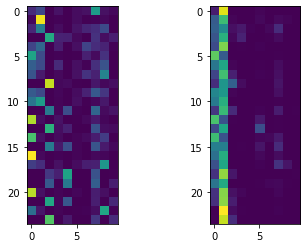

In [99]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(y_test_kmeans_by_group)
axes[1].imshow(y_pred_test_by_group)

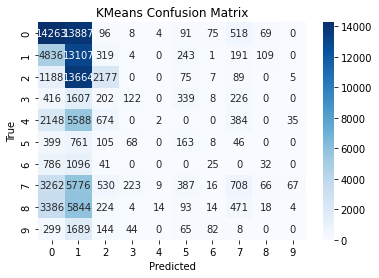

In [100]:
fig, ax = plot_confusion_matrix(y_test_kmeans, y_pred_test, classes=np.arange(10), title='KMeans Confusion Matrix')

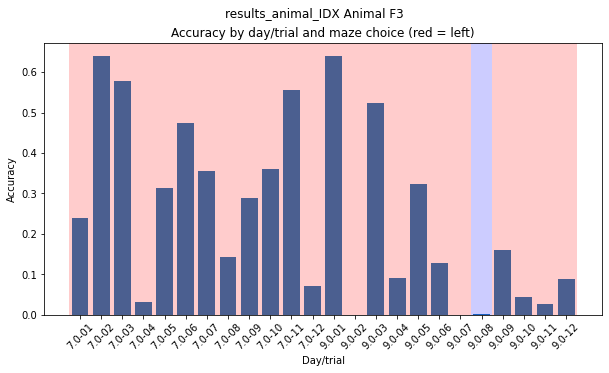

In [101]:
plot_accuracy_by_group(test_accuracy_by_group, group_to_maze_choice, fn_in)

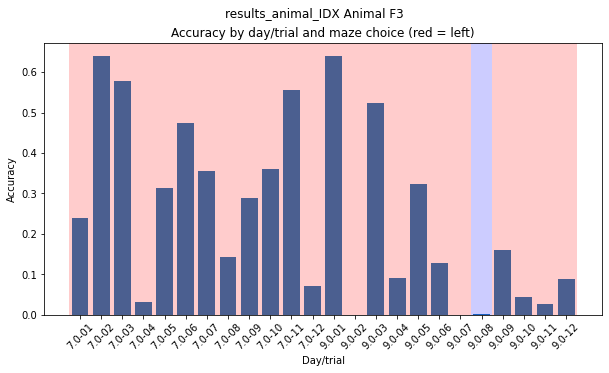

In [102]:
plot_accuracy_by_group(test_accuracy_by_group, group_to_maze_choice, fn_in)

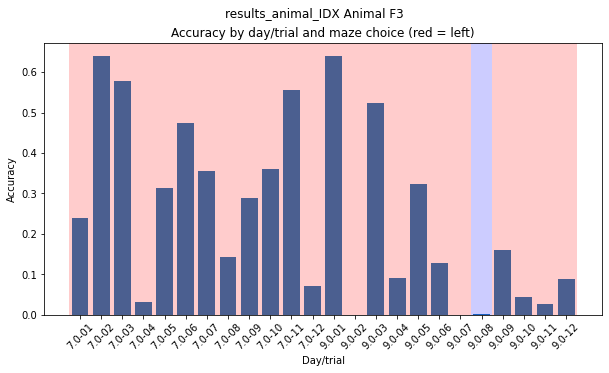

In [103]:
plot_accuracy_by_group(test_accuracy_by_group, group_to_maze_choice, fn_in)